In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.linalg import cholesky, solve_triangular

from modmcmc import State, BlockMCMCSampler, LogDensityTerm, TargetDensity
from modmcmc.kernels import MarkovKernel, GaussMetropolisKernel, DiscretePCNKernel, mvn_logpdf
import modmcmc as mm
from Gaussian import Gaussian
from helper import get_col_hist_grid, plot_trace, get_mwg_sampler, get_naive_cut_sampler, get_ep_rv, get_eup_rv, direct_sample_ep

In [2]:
rng = np.random.default_rng(532124)

# Set up linear Gaussian inverse problem and forward model emulator

In [17]:
# Linear Gaussian inverse problem

# Parameter and observation dimension
d = 2
n = 20

# Prior
m = rng.normal(size=d)
C_sqrt = rng.normal(size=(d,d))
C = C_sqrt @ C_sqrt.T
u = Gaussian(mean=m, cov=C, rng=rng)

# Linear forward model
G = rng.normal(size=(n,d))

# Noise covariance
Sig_sqrt = rng.normal(size=(n,n))
Sig = Sig_sqrt @ Sig_sqrt.T
noise = Gaussian(cov=Sig, rng=rng, store="both")

# Data
y = G @ u.sample() + noise.sample()

In [18]:
# Forward model emulator of the form f_star(u) = f(u) + e, e ~ N(r, Q)
q_scale = 0.2
r = rng.normal(size=n)
Q_sqrt = q_scale * rng.normal(size=(n,n))
Q = Q_sqrt @ Q_sqrt.T
e = Gaussian(mean=r, cov=Q, rng=rng)

# Comparing EP and EUP

In [19]:
u_post = u.invert_affine_Gaussian(y, A=G, cov_noise=noise.cov)
u_ep = get_ep_rv(y, u, G, noise, e)
u_eup = get_eup_rv(y, u, G, noise, e)

In [20]:
n_samp = 100000
samp_post = u_post.sample(n_samp)
samp_ep = u_ep.sample(n_samp)
samp_eup = u_eup.sample(n_samp)
# samp_ep2 = direct_sample_ep(y, u, G, Sig, e, n_samp)

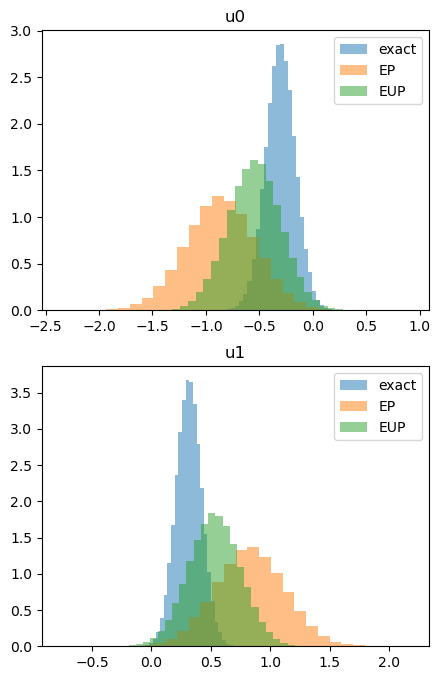

In [21]:
col_labs=[f"u{i}" for i in range(d)]
plot_labs = ["exact", "EP", "EUP"] #, "EP2"]

hist_plt = get_col_hist_grid(samp_post, samp_ep, samp_eup, bins=30, nrows=2, 
                             col_labs=col_labs, plot_labs=plot_labs)
plt.show()

# Compare exact EP vs MCMC-based approximations

## Approximate Metropolis-within-Gibbs

In [22]:
mwg = get_mwg_sampler(y, u, G, noise, e, rng, pcn_cor=0.99)

In [23]:
n_mcmc = 100000
mwg.sample(num_steps=n_mcmc)

samp_mcmc = np.empty((len(mwg.trace), u.dim))
for i in range(samp_mcmc.shape[0]):
    samp_mcmc[i,:] = mwg.trace[i].primary["u"]

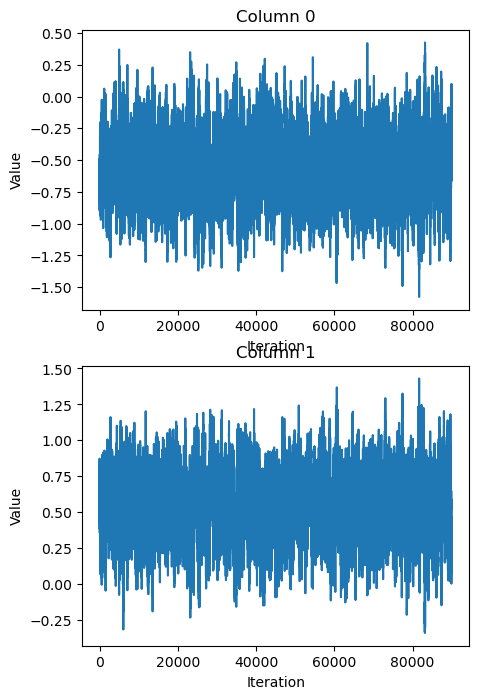

In [24]:
burn_in_start = 10000
trace_plots = plot_trace(samp_mcmc[burn_in_start:,:], nrows=2)
plt.show()

In [25]:
burn_in_start = 10000
samp_mcmc = samp_mcmc[burn_in_start:,:]

## Naive cut algorithm

In [26]:
cut_alg = get_naive_cut_sampler(y, u, G, noise, e, rng, u_prop_scale=0.1)

In [27]:
cut_alg.sample(num_steps=n_mcmc)

samp_cut = np.empty((len(cut_alg.trace), u.dim))
for i in range(samp_cut.shape[0]):
    samp_cut[i,:] = cut_alg.trace[i].primary["u"]

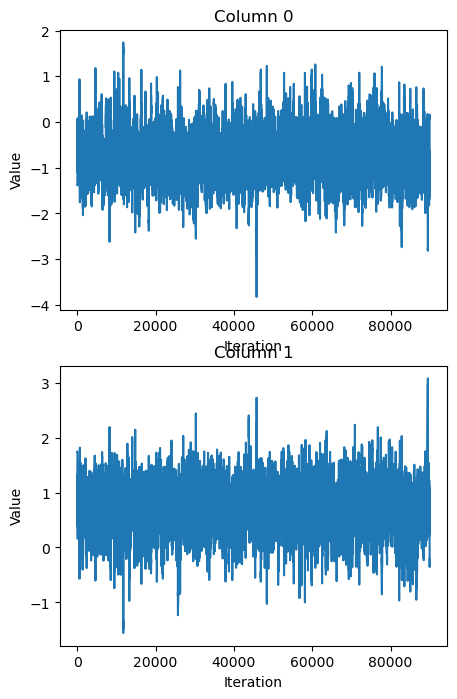

In [28]:
burn_in_start = 10000
trace_plots_cut = plot_trace(samp_cut[burn_in_start:,:], nrows=2)
plt.show()

In [29]:
burn_in_start = 10000
samp_cut = samp_cut[burn_in_start:,:]

## Comparison

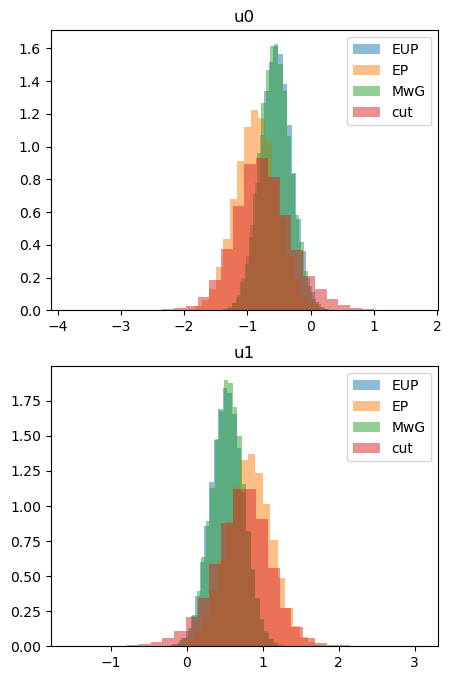

In [30]:
hist_plt_mcmc = get_col_hist_grid(samp_eup, samp_ep, samp_mcmc, samp_cut, bins=30, nrows=2, 
                                  col_labs=col_labs, plot_labs=["EUP", "EP", "MwG", "cut"])
plt.show()